In [1]:
import os
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import matplotlib.image as mpimg
import matplotlib.patches as patches
import plotly.graph_objects as go

from pathlib import Path
from PIL import Image

In [3]:
from tqdm import tqdm
import yaml
import cv2

In [4]:
import albumentations as A

!pip install ultralytics
import ultralytics
ultralytics.checks()
from ultralytics import YOLO
from ultralytics.utils import metrics

Ultralytics 8.3.39  Python-3.12.3 torch-2.5.1 CPU (11th Gen Intel Core(TM) i7-11390H 3.40GHz)
Setup complete  (8 CPUs, 15.7 GB RAM, 402.3/458.2 GB disk)


In [5]:
data_path = "C:/Users/muaaz/Downloads/Brain Tumor MRI Images for ML/"
print("Files in dataset folder:", os.listdir(data_path))

Files in dataset folder: ['dataset_yaml.yaml', 'Train', 'Val']


In [6]:
# Define the paths to the training and validation datasets
train_path = "C:/Users/muaaz/Downloads/Brain Tumor MRI Images for ML/Train/"
val_path = "C:/Users/muaaz/Downloads/Brain Tumor MRI Images for ML/Val/"

In [7]:
def load_data(directory):

    # Function to Load Images and Labels

    # Initialize empty lists to store images and their corresponding labels
    images = []
    labels = []

    # Loop through each class (subfolder) in the given directory
    for class_name in os.listdir(directory):
        # Construct the full path to the class folder
        class_path = os.path.join(directory, class_name)

        # Construct paths to the 'images' and 'labels' subfolders within the class folder
        images_path = os.path.join(class_path, 'images')
        labels_path = os.path.join(class_path, 'labels')

        # Check if the 'images' and 'labels' folders exist; skip the class if not
        if not os.path.exists(images_path) or not os.path.exists(labels_path):
            print(f"Missing 'images' or 'labels' folder in {class_path}. Skipping this class.")
            continue

        # Loop through each image file in the 'images' folder
        for image in os.listdir(images_path):
            # Construct the full path to the current image file
            img_path = os.path.join(images_path, image)

            # Read the image using OpenCV
            img = cv2.imread(img_path)

            # If the image cannot be read, skip it and print a warning
            if img is None:
                print(f"Failed to load image {img_path}, skipping.")
                continue

            # Convert the image from BGR (default OpenCV format) to RGB
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # Construct the corresponding label file name by replacing '.jpg' with '.txt'
            label_file = image.replace('.jpg', '.txt')
            label_file_path = os.path.join(labels_path, label_file)

            # Check if the label file exists
            if os.path.exists(label_file_path):
                # Open the label file and read its content
                with open(label_file_path, 'r') as file:
                    # Read the first line, strip extra whitespace, and split into components
                    label_data = file.readline().strip().split()

                    # If the label data is valid, store the image and its label
                    if len(label_data) > 0:
                        images.append(img)
                        labels.append(label_data)
                    else:
                        # Print a warning if the label file is empty
                        print(f"Label file {label_file_path} is empty, skipping this image.")
            else:
                # Print a warning if the label file does not exist
                print(f"Label file {label_file_path} not found, skipping this image.")

    # Return the loaded images and their corresponding labels
    return images, labels

In [8]:
# Load the training dataset
train_images, train_labels = load_data(train_path)
# Load the validation dataset
val_images, val_labels = load_data(val_path)

Label file C:/Users/muaaz/Downloads/Brain Tumor MRI Images for ML/Val/Glioma\labels\gg (342).txt is empty, skipping this image.
Label file C:/Users/muaaz/Downloads/Brain Tumor MRI Images for ML/Val/No Tumor\labels\image(55).txt not found, skipping this image.
Label file C:/Users/muaaz/Downloads/Brain Tumor MRI Images for ML/Val/No Tumor\labels\image(61).txt not found, skipping this image.


In [9]:
# Print the number of images and labels successfully loaded
print(f"\n Loaded {len(train_images)} training images and {len(train_labels)} labels.")
print(f" Loaded {len(val_images)} validation images and {len(val_labels)} labels.")


 Loaded 4737 training images and 4737 labels.
 Loaded 509 validation images and 509 labels.


In [10]:
# Mapping of class IDs to their corresponding names and colors
class_mapping = {
    0: ("Glioma", (0, 255, 0)),       # Green for Glioma
    1: ("Meningioma", (255, 0, 0)),   # Red for Meningioma
    2: ("No Tumor", (0, 0, 255)),      # Blue for No Tumor
    3: ("Pituitary", (255, 255, 0))    # Yellow for Pituitary
}

In [11]:
def visualize_random_images(images, labels, num_images=36):
    """
    Visualizes a grid of random images with their corresponding bounding boxes and class labels.

    Parameters:
    - images: List of images to visualize.
    - labels: List of labels corresponding to the images.
    - num_images: Number of images to display in the grid (default is 36).
    """
    # Select random indices from the range of available images
    random_indices = random.sample(range(len(images)), num_images)
    
    # Create a 6x6 grid for displaying the images
    fig, axs = plt.subplots(6, 6, figsize=(30, 23))  # Large figure size for better clarity

    # Loop through the selected random indices
    for i, idx in enumerate(random_indices):
        # Copy the image to avoid modifying the original during drawing
        image = images[idx].copy()  
        
        # Get the label data for the current image
        label_data = labels[idx]
        
        # If the label data contains bounding box information (assumes YOLO format: class_id, x_center, y_center, width, height)
        if len(label_data) == 5:  
            # Extract the label details and convert them to float
            class_id, x_center, y_center, width, height = map(float, label_data)

            # Calculate bounding box coordinates in pixel values
            x_min = int((x_center - width / 2) * image.shape[1])  # Convert normalized x_min to pixel value
            y_min = int((y_center - height / 2) * image.shape[0])  # Convert normalized y_min to pixel value
            x_max = int((x_center + width / 2) * image.shape[1])  # Convert normalized x_max to pixel value
            y_max = int((y_center + height / 2) * image.shape[0])  # Convert normalized y_max to pixel value

            # Get the class name and color from the mapping
            class_name, color = class_mapping.get(int(class_id), ("Unknown", (255, 255, 255)))

            # Draw the bounding box around the object with the specified color
            cv2.rectangle(image, (x_min, y_min), (x_max, y_max), color, 3)
            
            # Add the label (class name) above the bounding box
            label_text = f"{class_name}"
            cv2.putText(image, label_text, (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 
                        1, color, 2, cv2.LINE_AA)

        # Determine the grid position (row and column) for the current image
        row = i // 6  # Integer division to get the row index
        col = i % 6   # Modulus to get the column index

        # Display the image in the corresponding grid cell
        axs[row, col].imshow(image)
        axs[row, col].axis('off')  # Remove the axes for a cleaner look

    # Display the entire grid of images
    plt.show()

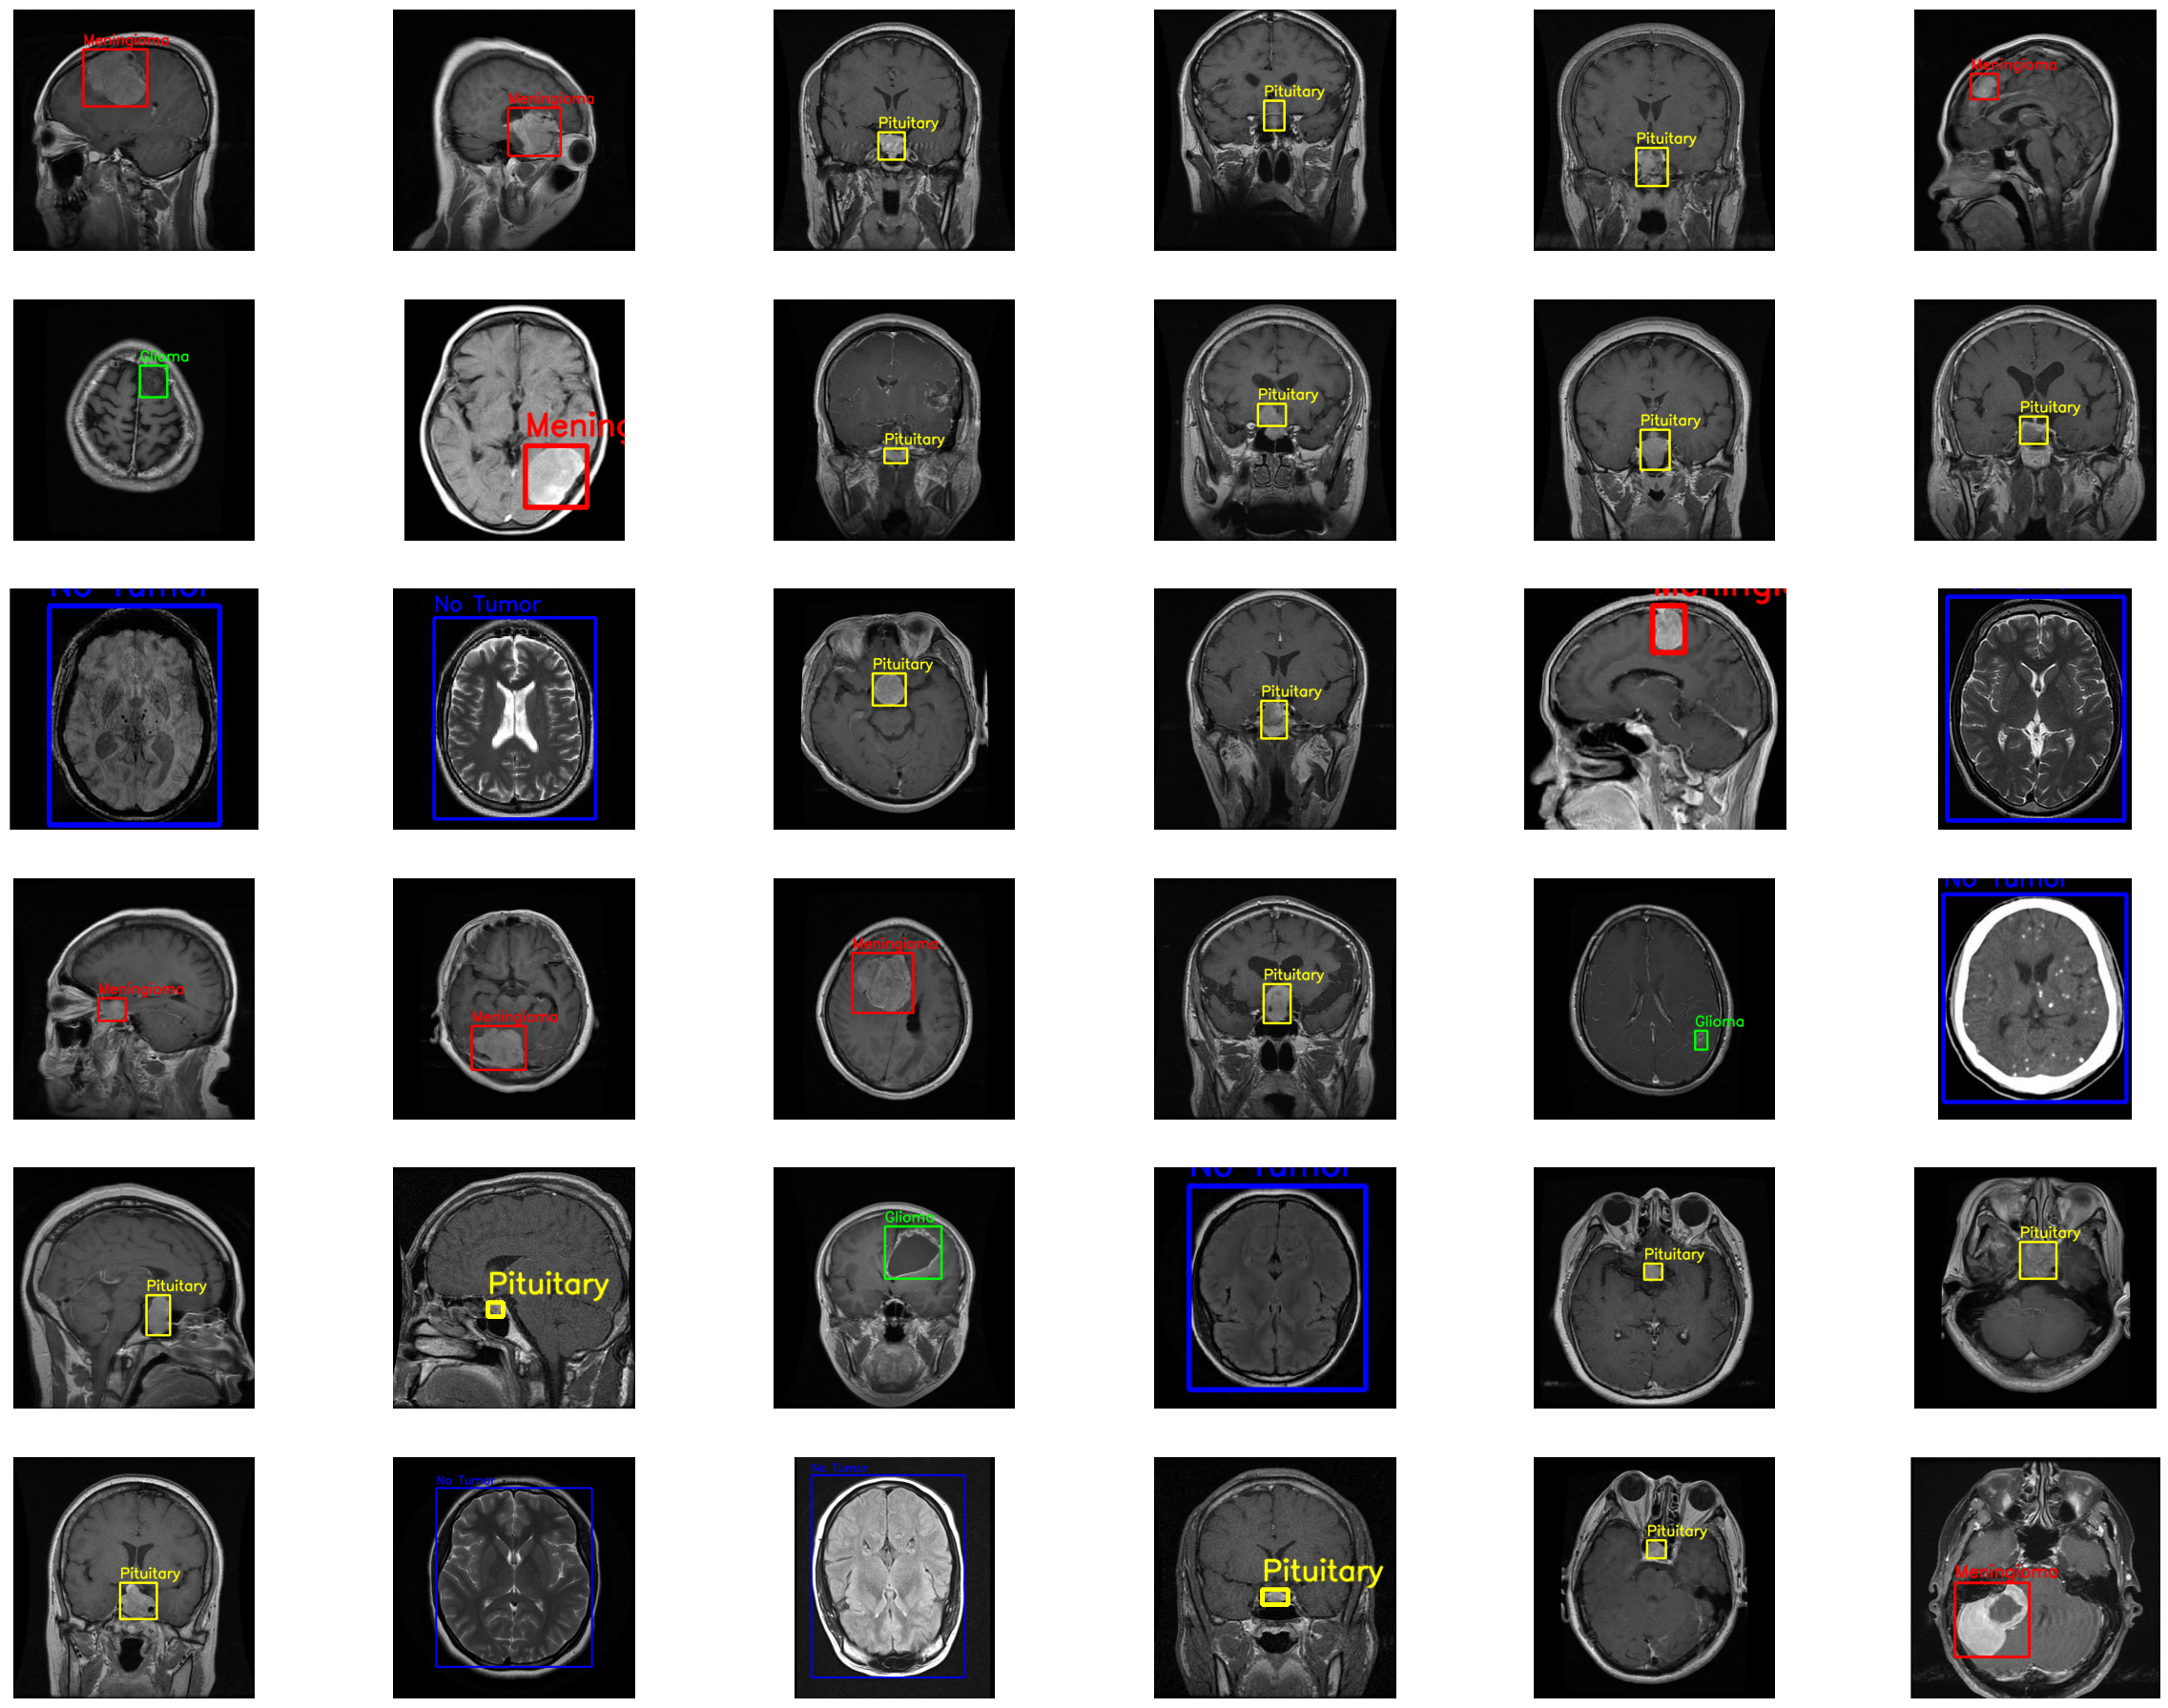

In [12]:
# Call the function to visualize random images from the training set
visualize_random_images(train_images, train_labels)

In [13]:
# import os  # Module for file and directory management
# import matplotlib.pyplot as plt  # Library for plotting

def plot_class_distribution(train_directory, val_directory):
    """
    Plots the distribution of images across different classes in the training and validation datasets.

    Parameters:
    - train_directory: The root directory containing subfolders for each class in the training set.
    - val_directory: The root directory containing subfolders for each class in the validation set.
    """
    train_counts = {}  # Dictionary to store the count of images in the training set
    val_counts = {}  # Dictionary to store the count of images in the validation set

    # Loop through each class folder in the training directory
    for class_name in os.listdir(train_directory):
        # Get the path to the 'images' subfolder for the current class
        train_images_path = os.path.join(train_directory, class_name, 'images')
        val_images_path = os.path.join(val_directory, class_name, 'images')

        # Count the number of image files in the training set
        if os.path.exists(train_images_path):
            train_counts[class_name] = len(os.listdir(train_images_path))
        else:
            train_counts[class_name] = 0  # If no images folder exists, set count to 0

        # Count the number of image files in the validation set
        if os.path.exists(val_images_path):
            val_counts[class_name] = len(os.listdir(val_images_path))
        else:
            val_counts[class_name] = 0  # If no images folder exists, set count to 0

    # Prepare data for plotting
    classes = list(train_counts.keys())
    train_values = [train_counts[class_name] for class_name in classes]
    val_values = [val_counts[class_name] for class_name in classes]

    # Set the positions and width for the bars
    x = range(len(classes))
    width = 0.35  # Width of the bars

    # Create the bar plot
    plt.figure(figsize=(12, 6))  # Set the figure size
    plt.bar(x, train_values, width=width, label='Training Set', color='skyblue', alpha=0.7)  # Training bars
    plt.bar([p + width for p in x], val_values, width=width, label='Validation Set', color='lightgreen', alpha=0.7)  # Validation bars

    # Add titles and labels
    plt.title('Image Count per Class (Training vs Validation)', fontsize=16, fontweight='bold')  # Title
    plt.xlabel('Class', fontsize=14)  # X-axis label
    plt.ylabel('Image Count', fontsize=14)  # Y-axis label
    plt.xticks([p + width / 2 for p in x], classes, rotation=45, fontsize=12)  # Center x-axis ticks
    plt.legend()  # Add legend
    plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add grid lines for y-axis
    plt.tight_layout()  # Adjust layout to prevent clipping
    plt.show()  # Display the plot

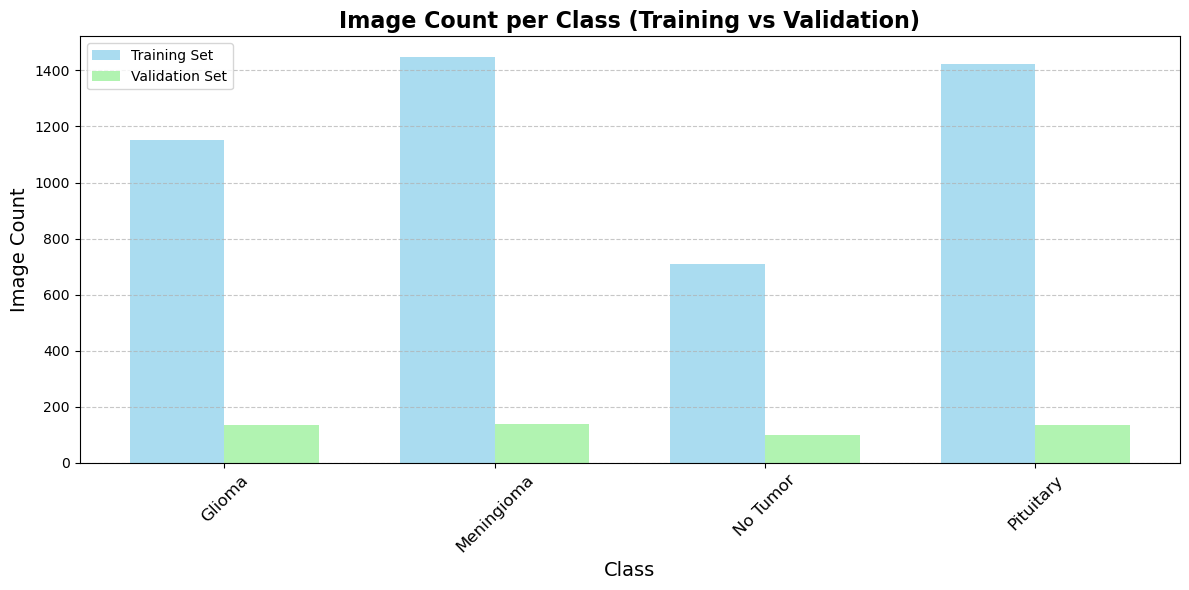

In [14]:
plot_class_distribution(train_path, val_path)

In [15]:
# import cv2  # OpenCV library for image processing
# import numpy as np  # NumPy library for handling arrays

def images_preprocessing(images):
    """
    Preprocesses a list of images by resizing them to a fixed size.

    Parameters:
    - images: List of input images to be processed.

    Returns:
    - processed_images: NumPy array of resized images.
    """
    processed_images = []  # List to store processed images
    for img in images:  # Iterate through each image in the input list
        # Resize the image to 640x640 pixels
        img_resized = cv2.resize(img, (640, 640))
        
        # Append the resized image to the processed_images list
        processed_images.append(img_resized)
    
    # Convert the list of processed images to a NumPy array for better handling
    return np.array(processed_images)

In [16]:
# Preprocess training images
train_images = images_preprocessing(train_images)  # Resize training images to 640x640

# Preprocess validation images
val_images = images_preprocessing(val_images)  # Resize validation images to 640x640

In [17]:
train_images.shape, val_images.shape

((4737, 640, 640, 3), (509, 640, 640, 3))

In [18]:
def display_random_images(directory, num_images=3):
    """
    Displays a random selection of images from each class in the specified directory.

    Parameters:
    - directory: The root directory containing subfolders for each class.
    - num_images: Number of images to randomly display per class (default is 3).
    """
    
    # Loop through each class folder in the directory
    for class_name in os.listdir(directory):
        # Get the path to the current class folder
        class_path = os.path.join(directory, class_name)
        
        # Path to the 'images' subfolder within the current class folder
        images_path = os.path.join(directory, class_name, 'images')
        
        # Get a list of all image filenames in the 'images' folder
        images = os.listdir(images_path)
        
        # Randomly select a specified number of images from the list
        selected_images = random.sample(images, num_images)
        
        # Create a figure with a 1x3 grid of subplots
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        # Add a title for the figure showing the current class name
        fig.suptitle(f"Displaying Images from {class_name}", fontsize=16, fontweight='bold')
        
        # Loop through the selected images and corresponding subplot axes
        for ax, image in zip(axes, selected_images):
            # Get the full path to the image
            image_path = os.path.join(images_path, image)
            
            # Read the image using matplotlib's image reader
            img = mpimg.imread(image_path)
            
            # Convert the image from BGR to RGB format for proper display
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            # Display the image on the current subplot axis
            ax.imshow(img)
            
            # Set the title of the subplot to the class name and image filename
            ax.set_title(f"{class_name} - {os.path.basename(image)}", fontweight='bold')
            
            # Remove the x and y ticks for a cleaner display
            ax.set_xticks([])
            ax.set_yticks([])

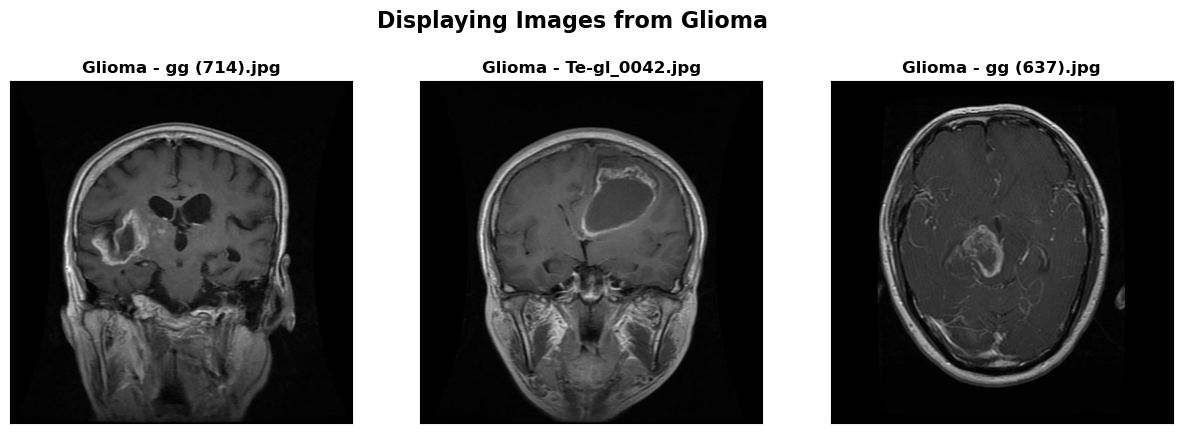

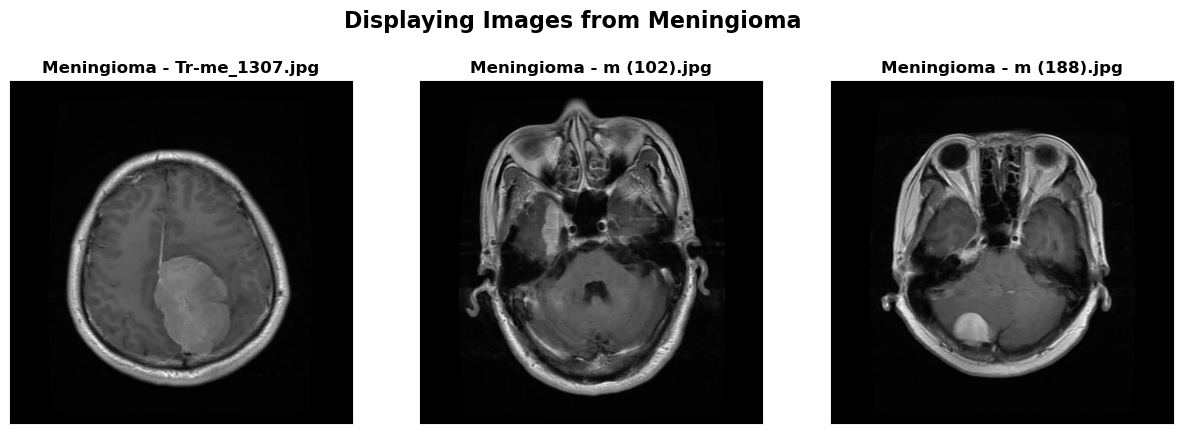

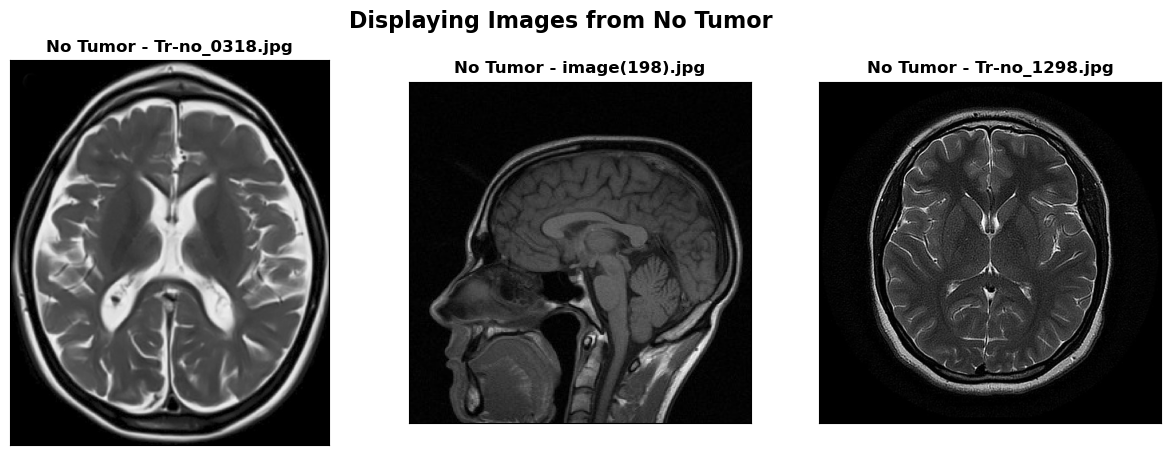

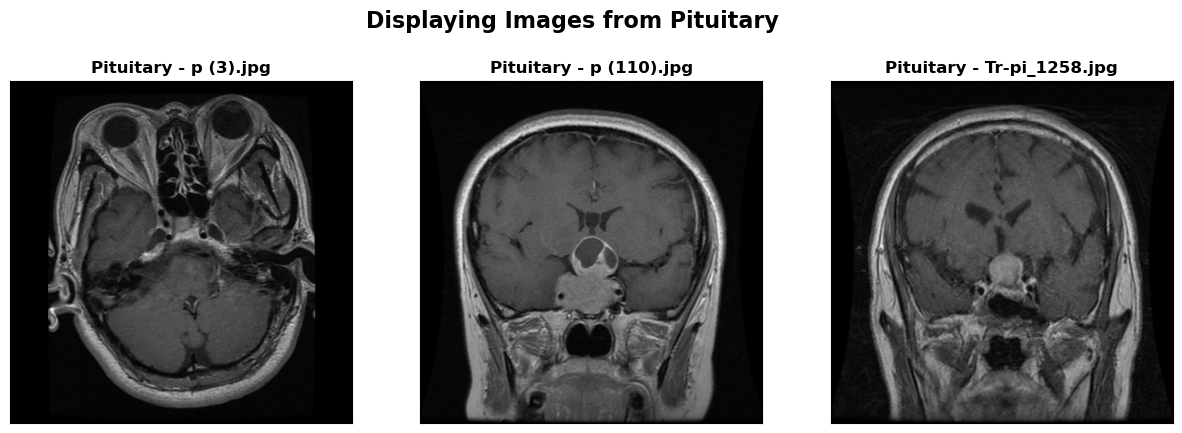

In [19]:
# Call the function to display random images from the training dataset
display_random_images(train_path)

In [20]:
import yaml  # Import the YAML library for handling YAML files

# Define the dataset configuration as a dictionary
dataset_yaml = {
    'path': 'C:/Users/muaaz/Downloads/Brain Tumor MRI Images for ML/',  # Base path for the dataset
    'train': 'C:/Users/muaaz/Downloads/Brain Tumor MRI Images for ML/Train/',  # Path to the training dataset
    'val': 'C:/Users/muaaz/Downloads/Brain Tumor MRI Images for ML/Val/',  # Path to the validation dataset
    'names': ["Glioma", "Meningioma", "No Tumor", "Pituitary"],  # Class names for the dataset
    'nc': 4  # Number of classes
}

# Specify the output path for the YAML file
output_yaml_path = 'C:/Users/muaaz/Downloads/Brain Tumor MRI Images for ML/dataset_yaml.yaml'

In [21]:
# Open the specified path in write mode to create or overwrite the YAML file
with open(output_yaml_path, 'w') as file:
    # Use yaml.dump() to write the dataset configuration to the file
    yaml.dump(dataset_yaml, file)

print(f"Dataset configuration saved to {output_yaml_path}")  # Confirm that the YAML file has been created


Dataset configuration saved to C:/Users/muaaz/Downloads/Brain Tumor MRI Images for ML/dataset_yaml.yaml


In [22]:
from ultralytics import YOLO  # Import the YOLO class from the Ultralytics package

In [23]:
# Load the YOLOv8 model with the specified weights
model = YOLO('yolo11s.pt')  # 'yolov8s.pt' is the pre-trained weights file for YOLOv8 Small model

100%|█████████████████████████████████████████████████████████████████████████████| 18.4M/18.4M [00:00<00:00, 26.1MB/s]


In [ ]:
# Train the model
train_results = model.train(
    data = output_yaml_path,  # Path to the dataset YAML configuration file
    epochs = 50,  # Number of training epochs (how many times to iterate over the training data)
    imgsz = 640,  # Size of images during training (640x640 pixels)
    device = "cpu",  # Specify the device to run the training (use 'cpu' or 'cuda' for GPU)
)

Ultralytics 8.3.39  Python-3.12.3 torch-2.5.1 CPU (11th Gen Intel Core(TM) i7-11390H 3.40GHz)
engine\trainer: task=detect, mode=train, model=yolo11s.pt, data=C:/Users/muaaz/Downloads/Brain Tumor MRI Images for ML/dataset_yaml.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cpu, workers=8, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, sav

train: Scanning C:\Users\muaaz\Downloads\Brain Tumor MRI Images for ML\Train\Glioma\labels.cache... 4737 images, 0 back

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning C:\Users\muaaz\Downloads\Brain Tumor MRI Images for ML\Val\Glioma\labels.cache... 510 images, 3 backgroun


Plotting labels to runs\detect\train3\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs\detect\train3
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50         0G      1.046      1.939      1.242          3        640: 100%|██████████| 297/297 [1:08:34<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [02:38

                   all        512        554      0.738      0.647      0.747      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50         0G      1.099      1.165      1.254          1        640: 100%|██████████| 297/297 [1:07:40<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [02:40

                   all        512        554      0.689       0.57      0.683       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50         0G      1.105      1.138      1.259          1        640: 100%|██████████| 297/297 [1:09:03<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [02:46

                   all        512        554      0.697      0.677      0.728      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50         0G       1.08      1.044      1.239          3        640: 100%|██████████| 297/297 [1:08:44<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [02:46

                   all        512        554       0.78      0.818      0.849      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50         0G      1.043     0.9567      1.217          3        640: 100%|██████████| 297/297 [3:40:23<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [02:50

                   all        512        554      0.865      0.821      0.901      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50         0G      1.003     0.8777      1.187          2        640: 100%|██████████| 297/297 [1:23:21<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [05:01

                   all        512        554       0.84      0.789       0.86      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50         0G      0.981     0.8477      1.183          4        640: 100%|██████████| 297/297 [1:44:26<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [02:44

                   all        512        554       0.92      0.831      0.923      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50         0G     0.9666     0.8073       1.17          2        640: 100%|██████████| 297/297 [1:10:08<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [02:44

                   all        512        554      0.851      0.831      0.886      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50         0G     0.9474     0.7742      1.159          1        640: 100%|██████████| 297/297 [1:09:56<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [02:39

                   all        512        554      0.876      0.796      0.897      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50         0G      0.934     0.7429      1.146          2        640: 100%|██████████| 297/297 [2:11:21<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [02:55

                   all        512        554      0.893      0.839      0.915      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50         0G      0.918     0.7175      1.133          1        640: 100%|██████████| 297/297 [1:11:27<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [02:41

                   all        512        554      0.873      0.891      0.927      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50         0G     0.9128     0.7168      1.146          2        640: 100%|██████████| 297/297 [1:35:40<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [02:43

                   all        512        554      0.896      0.872      0.922      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50         0G     0.8953     0.6918      1.133          2        640: 100%|██████████| 297/297 [1:14:02<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [02:41

                   all        512        554      0.859      0.886      0.927      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50         0G     0.8894     0.6868      1.126          3        640: 100%|██████████| 297/297 [1:14:18<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [02:43

                   all        512        554      0.912      0.895      0.943      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50         0G     0.8982     0.6791      1.127          2        640: 100%|██████████| 297/297 [1:16:03<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [02:40

                   all        512        554      0.897      0.859      0.934       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50         0G     0.8753     0.6535      1.115          2        640: 100%|██████████| 297/297 [1:14:25<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [02:49

                   all        512        554      0.908      0.892      0.947      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50         0G      0.859     0.6356      1.113          1        640: 100%|██████████| 297/297 [1:15:27<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [02:47

                   all        512        554      0.911      0.903       0.95      0.749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50         0G     0.8632     0.6279      1.108          1        640: 100%|██████████| 297/297 [1:15:11<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [02:47

                   all        512        554      0.917      0.897      0.941      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50         0G     0.8392     0.6007      1.099          1        640: 100%|██████████| 297/297 [1:13:59<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [02:46

                   all        512        554      0.911      0.906       0.94       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50         0G     0.8443     0.5981      1.099         22        640:  90%|████████▉ | 267/297 [1:07:06<07:11,

In [ ]:
# Export the model to ONNX format with a specified save directory and filename
path = model.export(format="onnx", save_dir='C:/Users/muaaz/Downloads/Brain Tumor MRI Images for ML/Model', name='YOLO11s_brain_tumor_model')

In [ ]:
# # Evaluate model performance on the validation set
# metrics = model.val()  # Validate the model on the validation dataset and retrieve metrics

# # Perform object detection on a single image
# results = model("path/to/image.jpg")  # Run inference on the specified image file
# results[0].show()  # Display the results, showing the image with detected objects

In [ ]:
# import random  # Module for generating random numbers and selections
# import matplotlib.pyplot as plt  # Library for creating visualizations
# from ultralytics import YOLO  # YOLO library for object detection
# import cv2  # OpenCV library for image processing
# import os  # Module for file and directory management

In [ ]:
# List of class names corresponding to class IDs
classes = ["Glioma", "Meningioma", "No Tumor", "Pituitary"]

# Assume `train_images` and `train_labels` are loaded from the training path
train_images, train_labels = load_data(train_path)  # Load data function (not shown here)

# Randomly select 36 images from the training dataset for visualization
sample_images = random.sample(train_images, 36)

# Create a 6x6 grid of subplots for displaying the images
fig, axs = plt.subplots(6, 6, figsize=(20, 20))  # Each subplot will display one image

# Iterate through each selected image
for i, image in enumerate(sample_images):

    # Use the YOLO model to make predictions on the image
    results = model.predict(image, imgsz=640)  # Predict with the image resized to 640x640

    # Iterate through the detected objects (bounding boxes) in the prediction results
    for result in results[0].boxes:
        # Extract bounding box coordinates (x1, y1, x2, y2)
        x1, y1, x2, y2 = map(int, result.xyxy[0])

        # Get the predicted class ID and corresponding class label
        class_id = int(result.cls[0])
        label = classes[class_id]

        # Draw a rectangle around the detected object in the image
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Green rectangle with thickness 2

        # Add the class label as text above the rectangle
        cv2.putText(image, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 3, (152, 215, 235), 3)
        # Text with blue-green color and size 3

    # Determine the position in the subplot grid
    row = i // 6  # Row index for the current subplot
    col = i % 6  # Column index for the current subplot

    # Display the processed image in the corresponding subplot
    axs[row, col].imshow(image)
    axs[row, col].axis('off')  # Hide axes for cleaner visualization

# Adjust spacing between subplots to prevent overlap
plt.tight_layout()

# Show the plot with all processed images
plt.show()


In [ ]:
# Evaluate model performance on the validation dataset
metrics = model.val(split='val')  # Perform validation on the 'val' split of the dataset


In [ ]:
print(metrics)

In [ ]:
print(f"Precision: {metrics['precision']}")
print(f"Recall: {metrics['recall']}")
print(f"mAP@0.5: {metrics['map50']}")
print(f"mAP@0.5:0.95: {metrics['map']}")

In [ ]:
# import os
# import cv2
# import matplotlib.pyplot as plt


In [ ]:

# List of directories containing validation images for each class
image_dirs = [
    "/kaggle/input/mri-for-brain-tumor-with-bounding-boxes/Val/Glioma/images",
    "/kaggle/input/mri-for-brain-tumor-with-bounding-boxes/Val/Meningioma/images",
    "/kaggle/input/mri-for-brain-tumor-with-bounding-boxes/Val/No Tumor/images",
    "/kaggle/input/mri-for-brain-tumor-with-bounding-boxes/Val/Pituitary/images"
]

# Gather all image filenames across the directories
all_images = []
for image_dir in image_dirs:
    # Add images with valid extensions to the list
    all_images += [img for img in os.listdir(image_dir) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]

# Select the first 50 images from the combined list for visualization
selected_images = all_images[:50]

# Loop through the selected images and process them
for img_name in selected_images:
    for image_dir in image_dirs:  # Search for the image in the respective class directories
        img_path = os.path.join(image_dir, img_name)
        if os.path.exists(img_path):  # Check if the image exists in the current directory
            # Perform prediction using the YOLO model
            results = model.predict(img_path)

            # Load the image using OpenCV and convert it to RGB for correct color representation
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # Process and overlay predictions on the image
            for result in results:
                plotted_img = result.plot()  # Get the image with bounding boxes and labels

                # Display the image with bounding boxes and labels
                plt.figure(figsize=(8, 6))  # Set the figure size
                plt.imshow(plotted_img)  # Display the processed image
                plt.axis('off')  # Turn off axis labels for better visualization
                plt.show()  # Show the image

            break  # Stop searching after the image is found in a directory
